# ICP Registration and Alignment of an Airborne Lidar and UAV Pointcloud

*Bodo Bookhagen [bodo.bookhagen@uni-potsdam.de](mailto:bodo.bookhagen@uni-potsdam.de)*

## Example and walk through of point-cloud alignment of two real-world datasets using Open3D

We use an airborne lidar dataset and a UAV (SODA camera on an ebee system) point cloud and align them. We align a downsampled version of these point clouds to speed up the processing.

## 0. Initiate python module imports and define some useful functions

In [1]:
import copy, sys, os
import numpy as np

import matplotlib.pyplot as pl

import open3d as o3d
import laspy

#Generate function to plot two point clouds in different colors
def draw_2pcd(pcd1, pcd2):
    pcd1_temp = copy.deepcopy(pcd1)
    pcd2_temp = copy.deepcopy(pcd2)
    pcd1_temp.paint_uniform_color([1, 0.706, 0]) #orange
    pcd2_temp.paint_uniform_color([0, 0.651, 0.929]) #cyan
    o3d.visualization.draw_geometries([pcd1_temp, pcd2_temp])

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0]) #orange
    target_temp.paint_uniform_color([0, 0.651, 0.929]) #cyan
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
    
def get_colors(inp, colormap, vmin=None, vmax=None):
    if vmin == None:
        vmin=np.nanmin(inp)
    if vmax == None:
        vmax=np.nanmax(inp)
    norm = pl.Normalize(vmin, vmax)
    return colormap(norm(inp))

def get_colors_log(inp, colormap, vmin=None, vmax=None):
    if vmin == None:
        vmin=np.nanmin(np.log10(inp))
    if vmax == None:
        vmax=np.nanmax(np.log10(inp))
    norm = pl.Normalize(vmin, vmax)
    return colormap(norm(inp))


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. Load ALS point clouds into a numpy array and Open3D point cloud

Load ALS PC as `pc1` and stored as `pcd` Open3D Point Cloud. Create a 1 m downsampled version.

**The ALS dataset is the reference point cloud.**

**The dataset is available via dropbox at:
[https://www.dropbox.com/s/luak66coy8sl22l/ALS2018_UP_Golm_06May2018.laz?dl=0](https://www.dropbox.com/s/luak66coy8sl22l/ALS2018_UP_Golm_06May2018.laz?dl=0)**

In [2]:
pc_path = '.'
pc_fn = 'ALS2018_UP_Golm_06May2018.laz'
pc1 = laspy.read(os.path.join(pc_path, pc_fn))

#Load the scaled x, y, z points into an nx3 numpy array
xyz = np.vstack((pc1.x, pc1.y, pc1.z)).transpose()
print('Loaded %d points'%xyz.shape[0])

# Pass xyz to Open3D.o3d.geometry.PointCloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
print('pcd:', pcd)
pcd_1m = pcd.voxel_down_sample(voxel_size=1)
pcd_1m.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=3, max_nn=30))
pcd_1m.orient_normals_to_align_with_direction([0., 0., 1.])
print('pcd_1m: ', pcd_1m)

Loaded 13058731 points
pcd: PointCloud with 13058731 points.
pcd_1m:  PointCloud with 640668 points.


In [3]:
o3d.visualization.draw_geometries([pcd_1m])

In [4]:
draw_2pcd(pcd, pcd_1m)

If you would like to save memory (or if you have less memory available), you can remove the full-resolution point cloud (the `!cat` only works on Linux systems)

In [5]:
!cat /proc/meminfo | grep Mem

MemTotal:       65797508 kB
MemFree:        15139616 kB
MemAvailable:   56190716 kB


In [6]:
pc1 = None
xyz = None
rgb = None
pcd = None

In [7]:
!cat /proc/meminfo | grep Mem

MemTotal:       65797508 kB
MemFree:        16126656 kB
MemAvailable:   57183568 kB


## 2. Load UAV pointcloud. This will be `pc2` and stored as `pcd2`.

**The UAV dataset is the point cloud that will be aligned to the ALS data.**

**The dataset is available via dropbox at:
[https://www.dropbox.com/s/jm21y9yvnqtzmc1/UAV2018_UP_Golm_ebee_SODA_04May2018.laz?dl=0](https://www.dropbox.com/s/jm21y9yvnqtzmc1/UAV2018_UP_Golm_ebee_SODA_04May2018.laz?dl=0)**

In [8]:
pc_path = '.'
pc_fn2 = 'UAV2018_UP_Golm_ebee_SODA_04May2018.laz'
pc2 = laspy.read(os.path.join(pc_path, pc_fn2))

#Load the scaled x, y, z points into an nx3 numpy array
xyz2 = np.vstack((pc2.x, pc2.y, pc2.z)).transpose()
print('Loaded %d points'%xyz2.shape[0])
rgb2 = np.vstack((pc2.red, pc2.green, pc2.blue)).transpose()

# Pass xyz to Open3D.o3d.geometry.PointCloud
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(xyz2)
pcd2.colors = o3d.utility.Vector3dVector(rgb2/65535)
print('pcd2:', pcd2)
pcd2_1m = pcd2.voxel_down_sample(voxel_size=1)
pcd2_1m.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=3, max_nn=30))
pcd2_1m.orient_normals_to_align_with_direction([0., 0., 1.])
print('pcd2_1m: ', pcd2_1m)

Loaded 24826752 points
pcd2: PointCloud with 24826752 points.
pcd2_1m:  PointCloud with 478893 points.


In [9]:
o3d.visualization.draw_geometries([pcd2_1m])

In [10]:
draw_2pcd(pcd2, pcd2_1m)

Free up some memory:

In [11]:
pc2 = None
xyz2 = None
rgb2 = None
pcd2 = None

#### Let's look at both point clouds using a single, distinct color for each point cloud (easier to distinguish):

In [12]:
draw_2pcd(pcd_1m, pcd2_1m)

## 3. Perform initial filtering step: Outlier Filtering

There is still significant noise in both point clouds. There are erroneous reflections in the airborne lidar point cloud and the UAV point cloud also contains some noise. It will be useful to filter these point clouds before using them. This could have been done at an earlier point as well.

### Statistical outlier removal
We are using a statistical outlier filter that removes points that are too far away from each other. It is based on a kd-tree that identifies a neighborhood (e.g., 20 neighbors) and determines their spread or variance. If this variance is larger than a certain threshold compared to the point cloud average, outlier points are removed. Similiar filtering implementations are included in CloudCompare and PDAL.

In [10]:
pcd_1m.remove_statistical_outlier?

Docstring:
remove_statistical_outlier(self, nb_neighbors, std_ratio, print_progress=False)
Function to remove points that are further away from their neighbors in average

Args:
    nb_neighbors (int): Number of neighbors around the target point.
    std_ratio (float): Standard deviation ratio.
    print_progress (bool, optional, default=False): Set to True to print progress bar.

Returns:
    Tuple[open3d.geometry.PointCloud, List[int]]
Type:      method


In [14]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

#### Filter ALS point cloud (pcd)

In [15]:
print(pcd_1m)
cl, ind = pcd_1m.remove_statistical_outlier(nb_neighbors=6,
                                                    std_ratio=2)
print(len(ind))
display_inlier_outlier(pcd_1m, ind)

PointCloud with 640668 points.
634014
Showing outliers (red) and inliers (gray): 


This step is usually done several times - always better to perform this multiple times with slightly adjusted parameters.

In [16]:
pcd_1m2 = pcd_1m.select_by_index(ind)
print(pcd_1m2)
cl, ind = pcd_1m2.remove_statistical_outlier(nb_neighbors=8,
                                                    std_ratio=2)
print(len(ind))
display_inlier_outlier(pcd_1m2, ind)

PointCloud with 634014 points.
622576
Showing outliers (red) and inliers (gray): 


In [17]:
pcd_1m3 = pcd_1m2.select_by_index(ind)
cl, ind = pcd_1m3.remove_statistical_outlier(nb_neighbors=10,
                                                    std_ratio=2)
display_inlier_outlier(pcd_1m3, ind)

Showing outliers (red) and inliers (gray): 


Once you are satisfied with output, overwrite the original point cloud: 

In [18]:
pcd_1m = pcd_1m3.select_by_index(ind)
pcd_1m3 = None
pcd_1m2 = None
o3d.visualization.draw_geometries([pcd_1m])

#### Repeat Filtering for UAV point cloud (pcd2)

In [19]:
cl, ind = pcd2_1m.remove_statistical_outlier(nb_neighbors=10,
                                                    std_ratio=1)
display_inlier_outlier(pcd2_1m, ind)

Showing outliers (red) and inliers (gray): 


Repeat several times, until point cloud is clean:

In [20]:
pcd2_1m2 = pcd2_1m.select_by_index(ind)
cl, ind = pcd2_1m2.remove_statistical_outlier(nb_neighbors=8,
                                                    std_ratio=1.5)
display_inlier_outlier(pcd2_1m2, ind)

Showing outliers (red) and inliers (gray): 


In [21]:
pcd2_1m3 = pcd2_1m2.select_by_index(ind)
cl, ind = pcd2_1m3.remove_statistical_outlier(nb_neighbors=96,
                                                    std_ratio=1.5)
display_inlier_outlier(pcd2_1m3, ind)

Showing outliers (red) and inliers (gray): 


In [22]:
pcd2_1m4 = pcd2_1m3.select_by_index(ind)
cl, ind = pcd2_1m4.remove_statistical_outlier(nb_neighbors=96,
                                                    std_ratio=2)
display_inlier_outlier(pcd2_1m4, ind)

Showing outliers (red) and inliers (gray): 


In [23]:
pcd2_1m = pcd2_1m4.select_by_index(ind)
pcd2_1m4 = None
pcd2_1m3 = None
pcd2_1m2 = None
o3d.visualization.draw_geometries([pcd2_1m])

## 4. Measure initial offset of point clouds

We use cKDTree to calculate distances between the point clouds. We can either use a open3d instance or the numpy point cloud.

In [24]:
np.asarray(pcd2_1m.points)

array([[3.62585341e+05, 5.80840359e+06, 1.01358000e+02],
       [3.62586925e+05, 5.80840561e+06, 1.02201500e+02],
       [3.62588250e+05, 5.80840490e+06, 1.02106500e+02],
       ...,
       [3.62204766e+05, 5.80854726e+06, 7.43852500e+01],
       [3.62468065e+05, 5.80837318e+06, 7.97013051e+01],
       [3.62205508e+05, 5.80854778e+06, 7.42445000e+01]])

### Using KDTree to calculate Hausdorff, modified Hausdorff, and Chamfer distances

This is the worst-case distance and is heavily dependend on outliers.

In [25]:
from scipy.spatial import cKDTree
A = np.asarray(pcd_1m.points)
B = np.asarray(pcd2_1m.points)

# Calculate distances for each point cloud
d1, _ = cKDTree(A).query(B, k=1, workers=-1)
d2, _ = cKDTree(B).query(A, k=1, workers=-1)

#### Visualizing distances in space and as distribution

The measured nearest neighbor distances can be plotted as distribution for each point cloud. The distributions can be different, because point clouds have different spatial resolution, accuracy and may have a very different characteristic of outliers.

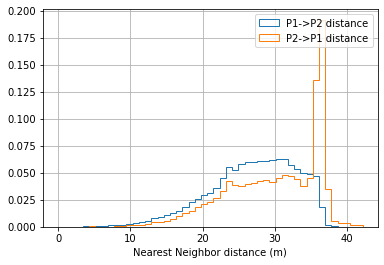

In [26]:
bins50 = np.linspace(0, np.max(d1), 50, endpoint=True)
pl.hist(d1, bins=bins50, density=True, histtype='step', label='P1->P2 distance')
pl.hist(d2, bins=bins50, density=True, histtype='step', label='P2->P1 distance')
pl.legend()
pl.xlabel('Nearest Neighbor distance (m)')
pl.grid()

#### But distances can also be visualized spatially:

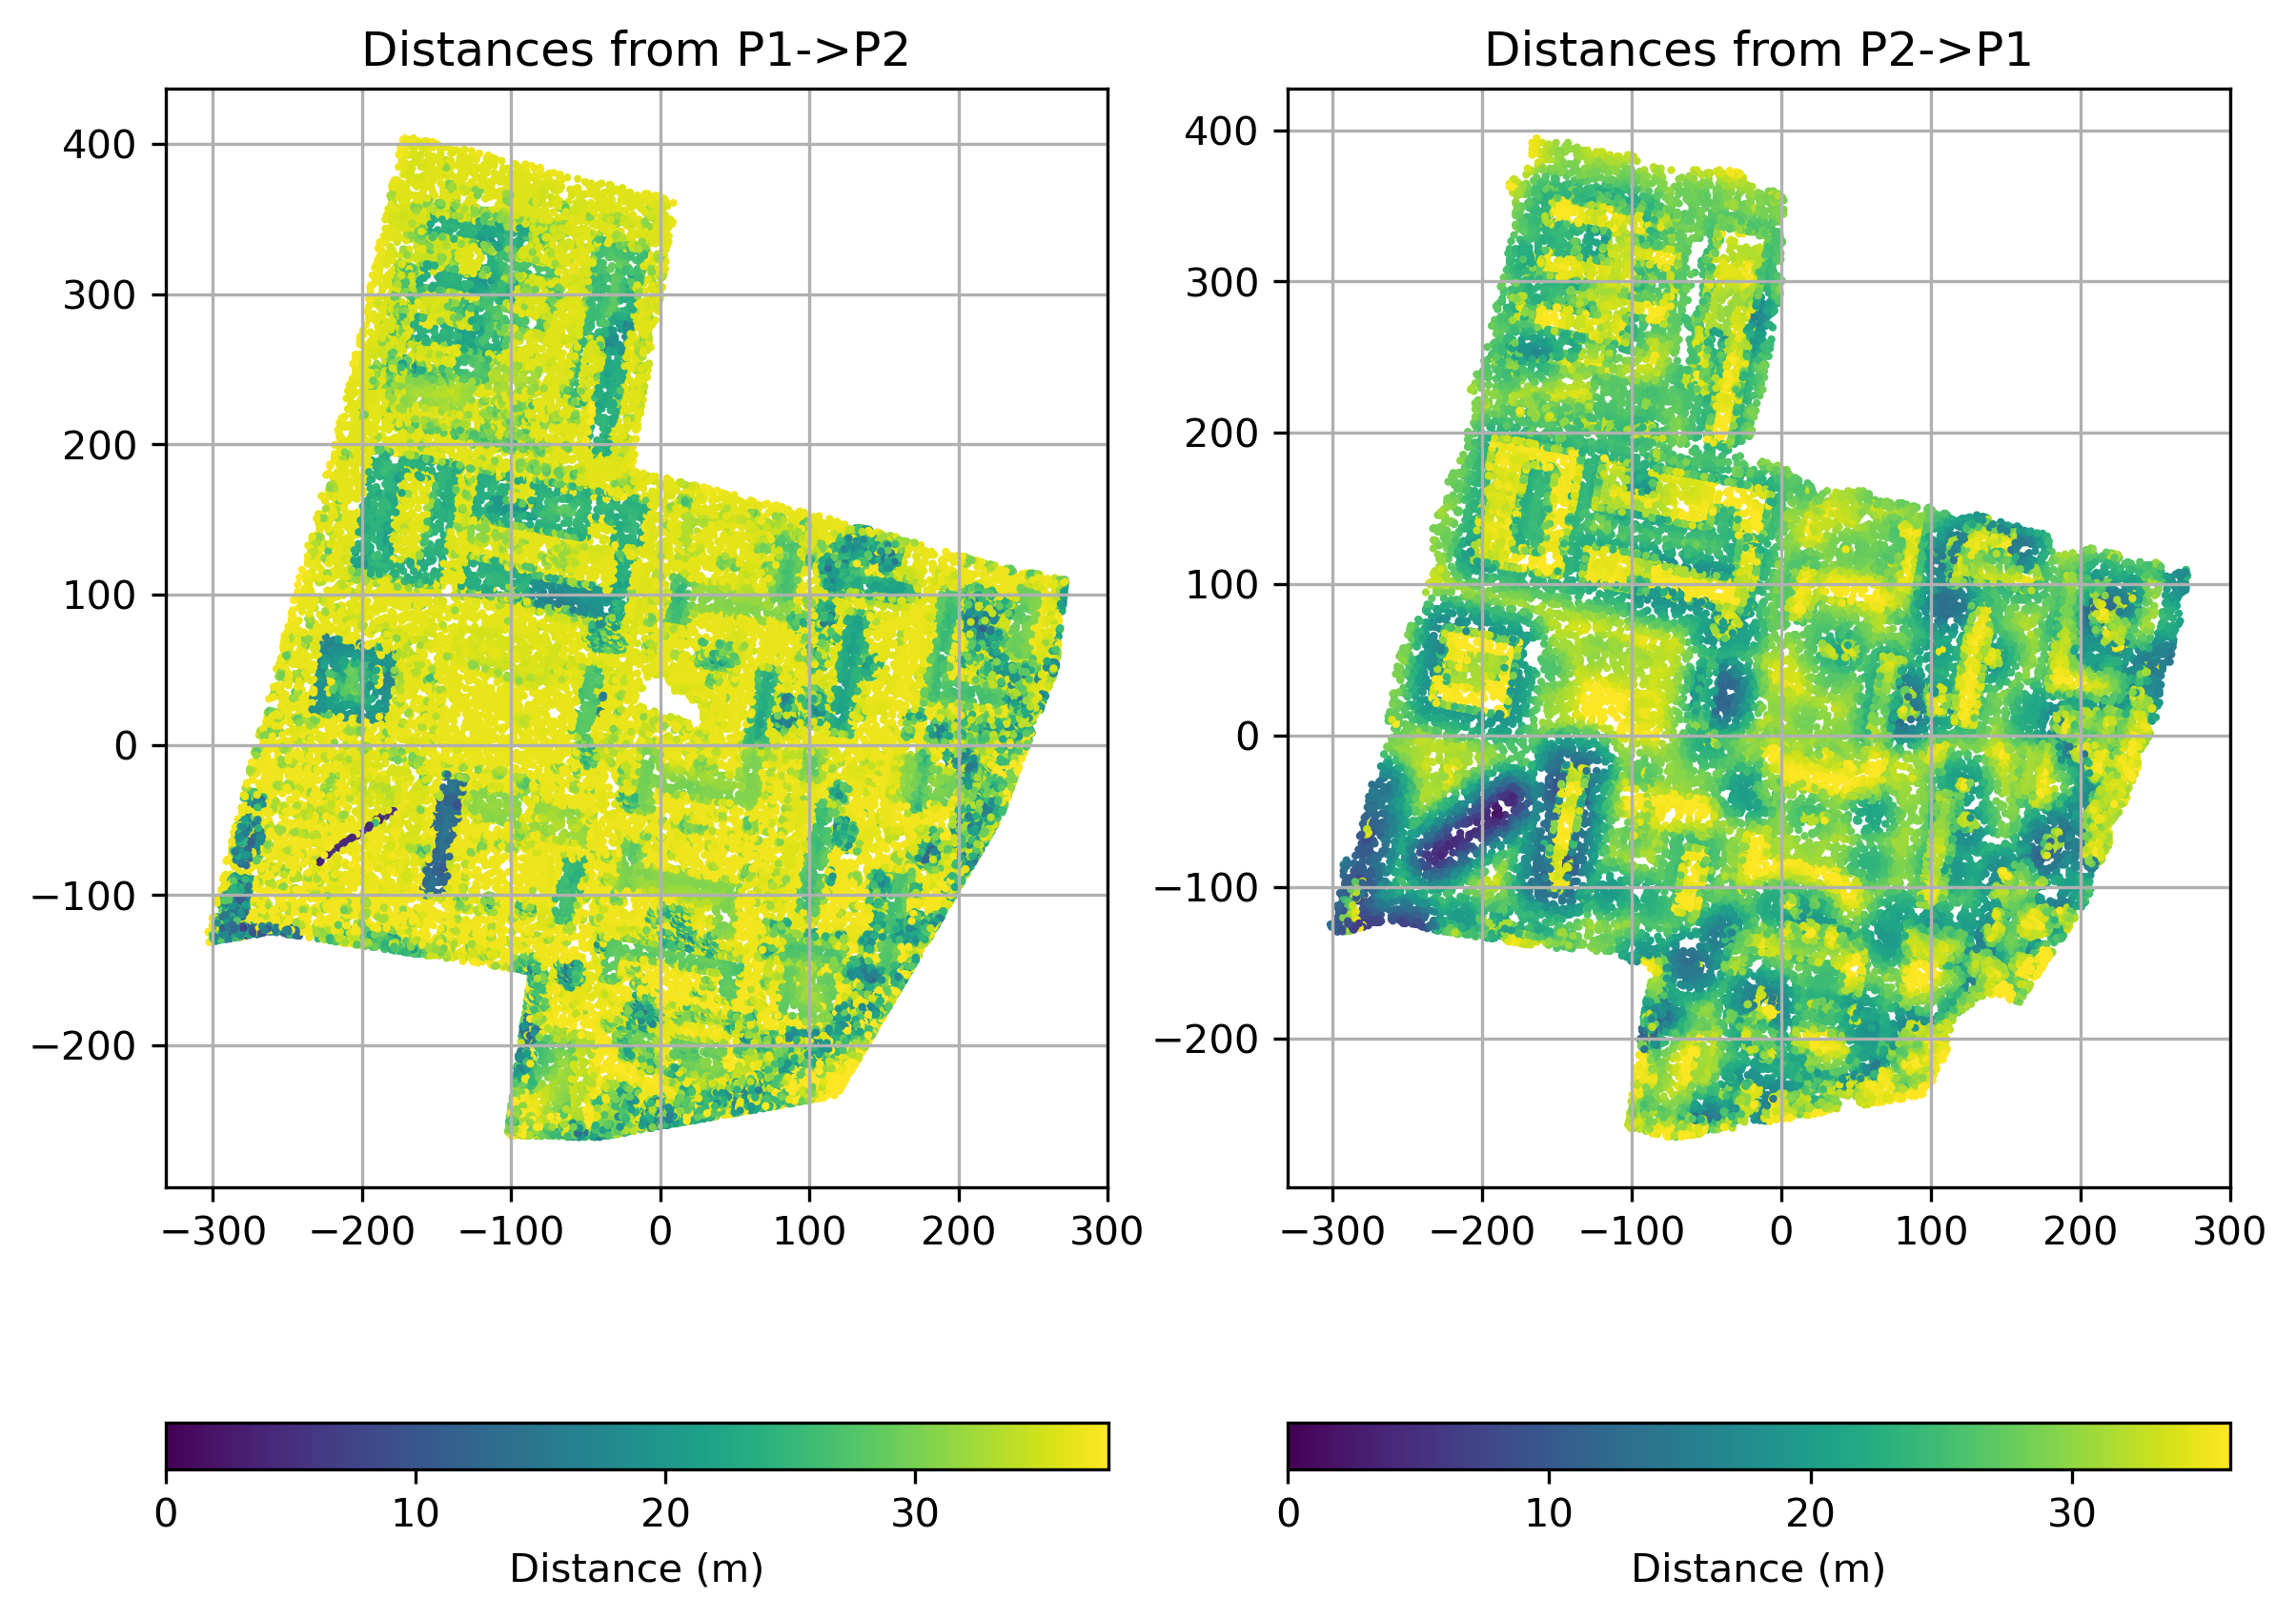

In [27]:
fg, ax = pl.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=300)
x_mean = np.mean(A[::10,0])
y_mean = np.mean(A[::10,1])

im0 = ax[0].scatter(A[::10,0]-x_mean, 
                   A[::10,1]-y_mean, 
           c=d2[::10], s=1, cmap='viridis',
                   vmin=0,
                  vmax=np.percentile(d2[::10],98))
ax[0].grid()
ax[0].set_title('Distances from P1->P2')
cb0=pl.colorbar(im0, ax=ax[0], orientation='horizontal')
cb0.set_label('Distance (m)')

im1 = ax[1].scatter(B[::10,0]-x_mean, 
                   B[::10,1]-y_mean, 
           c=d1[::10], s=1, cmap='viridis',
                   vmin=0,
                  vmax=np.percentile(d1[::10],98))
ax[1].grid()
ax[1].set_title('Distances from P2->P1')
cb1=pl.colorbar(im1, ax=ax[1], orientation='horizontal')
cb1.set_label('Distance (m)')

fg.tight_layout()

#### Hausdorff Distance

Uses the maximum distance between two sets of points. Often described as the **worst case scenario** distance.

[https://en.wikipedia.org/wiki/Hausdorff_distance](https://en.wikipedia.org/wiki/Hausdorff_distance)

$$
d_{H}(X, Y)=\max \left\{\sup _{x \in X} d(x, Y), \sup _{y \in Y} d(X, y)\right\}
$$


In [28]:
Hausdorf_D = np.max([np.max(d1), np.max(d2)])
print(Hausdorf_D)

54.39433919970216


#### Modified Hausdorff Distance

Uses the sum of the mean of the minimum distance between two sets of points. Provides a more realistic scenario and is less prone to outliers.

Described in: [https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1.8155&rep=rep1&type=pdf](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1.8155&rep=rep1&type=pdf)


See also: [https://ieeexplore.ieee.org/document/576361](https://ieeexplore.ieee.org/document/576361)
"Based on experiments on synthetic images containing various levels of noise, the authors determined that one of these distance measures, called the modified Hausdorff distance (MHD) has the best performance for object matching."

It requires the calculation of the mean forward and backward distances:
```python
FHD = np.mean(np.min(d1)
# Calculating the reverse HD: mean(min(each row))
RHD = np.mean(np.min(d2)
# Calculating mhd
MHD = np.max(np.array([FHD, RHD]))
```

Which can be implemented in a one-liner:

In [29]:
MHausdorf_D = np.max([np.mean(d1), np.mean(d2)])
print(MHausdorf_D)

30.093601744212535


#### Chamfer Distance

Uses the minimum distance between two sets of points. This is the **best case scenario**.

For each point in each cloud, the Chamfer Distance finds the nearest point in the other point set, and sums up the square of distances.

$$
\operatorname{CD}\left(S_{1}, S_{2}\right)=\frac{1}{\left|S_{1}\right|} \sum_{x \in S_{1}} \min _{y \in S_{\mathbf{z}}}\|x-y\|_{2}^{2}+\frac{1}{\left|S_{2}\right|} \sum_{y \in S_{\mathbf{z}}} \min _{x \in S_{1}}\|x-y\|_{2}^{2}
$$

Usually implemented as a bidirection sum:
$$
sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
$$

In [30]:
Chamfer_D = np.mean(np.square(d1)) + np.mean(np.square(d2))
print(Chamfer_D)
print('%2.2e'%Chamfer_D)

1710.188870087415
1.71e+03


Note that the implementation in pdal (see below) is slightly different (using the sum and not the mean) and defined as:

$$
d_{CD}(X,Y) = \sum_{x \in X} \operatorname*{min}_{y \in Y} ||x-y||^2_2 + \sum_{y \in Y} \operatorname*{min}_{x \in X} ||x-y||^2_2
$$

In [31]:
Chamfer_D = np.sum(np.square(d1)) + np.sum(np.square(d2))
print(Chamfer_D)
print('%2.2e'%Chamfer_D)

913894771.6513205
9.14e+08


#### Alternative distance evaluation
Using a single value to determine the minimum, averaged, or maximum distance will always be biased. Instead of using a single value, one can look at the entire distance distribution of the nearest neighbor.

There is an implementation of this and this is commonly referred to as *Earth Mover's Distance (EMD)* ([https://en.wikipedia.org/wiki/Earth_mover%27s_distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance)). It is computationally expensive. There are python implementations available, but these often require CUDA/GPU processing and we are not looking into this in at this point.

### PDAL implementation

**NOTE that these are slow (10-20 minutes) because this is just a single-core application. Also, the calculations are done on the full-resolution point clouds.**

This is also implemented in PDAL and can be carried out via the command line:

```
pdal hausdorff <source> <candidate>
```
[https://pdal.io/apps/hausdorff.html](https://pdal.io/apps/hausdorff.html)


```bash
pdal hausdorff ../data/UAV2018_UP_Golm_ebee_SODA_04May2018.laz ../data/ALS2018_UP_Golm_06May2018_RGB.laz
```

which results in:
```json
{
  "filenames":
  [
    "../data/UAV2018_UP_Golm_ebee_SODA_04May2018.laz",
    "../data/ALS2018_UP_Golm_06May2018_RGB.laz"
  ],
  "hausdorff": 70.93594159,
  "modified_hausdorff": 29.40398167,
  "pdal_version": "2.4.0 (git-version: ef42f2)"
}
```


Similarily, you can calculate the Chamfer Distance via pdal:
[https://pdal.io/apps/chamfer.html](https://pdal.io/apps/chamfer.html)

```bash
pdal chamfer ../data/UAV2018_UP_Golm_ebee_SODA_04May2018.laz ../data/ALS2018_UP_Golm_06May2018_RGB.laz
```

which results in:
```json
{
  "chamfer": 3.064015886e+10,
  "filenames":
  [
    "../data/UAV2018_UP_Golm_ebee_SODA_04May2018.laz",
    "../data/ALS2018_UP_Golm_06May2018_RGB.laz"
  ],
  "pdal_version": "2.4.0 (git-version: ef42f2)"
}

```

## 5. Perform global (initial) alignment with 5 m downsampled point clouds

The first steps include to perform an initial, coarse alignment to get the point clouds close to each other. The search for corresponding points is modified by identifying features. See *Fast Point Feature Histograms (FPFH) for 3D registration"*" ([https://ieeexplore.ieee.org/document/5152473](https://ieeexplore.ieee.org/document/5152473)) for more information.

In [42]:
o3d.pipelines.registration.registration_fgr_based_on_correspondence?

In [43]:
o3d.pipelines.registration.registration_fgr_based_on_feature_matching?

In order to significantly speed up processing, we are voxelizing the data to 5 m.

In [33]:
voxel_size = 5
source_5m = pcd2_1m.voxel_down_sample(voxel_size=voxel_size) #point cloud you want to align (to be moved)
target_5m = pcd_1m.voxel_down_sample(voxel_size=voxel_size) # reference point cloud

In [34]:
radius_feature = voxel_size * 5
print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
source_5m_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    source_5m,
    o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

target_5m_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    target_5m,
    o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

:: Compute FPFH feature with search radius 25.000.


In [188]:
source_5m_fpfh

Feature class with dimension = 33 and num = 15943
Access its data via data member.

In [189]:
source_5m_fpfh.data.shape

(33, 15943)

In [190]:
source_5m_fpfh.data[0,:].shape

(15943,)

#### Visualization of the Fast Point Feature Histograms (FPFH) feature in 2D
See Rusu et al. (2009) at: [https://www.cvl.iis.u-tokyo.ac.jp/class2017/2017w/papers/5.3DdataProcessing/Rusu_FPFH_ICRA2009.pdf](https://www.cvl.iis.u-tokyo.ac.jp/class2017/2017w/papers/5.3DdataProcessing/Rusu_FPFH_ICRA2009.pdf).

"Point Feature Histograms (PFH) are robust multi-dimensional features
which describe the local geometry around a point p for 3D point
cloud datasets. Point Feature Histograms (PFH) are informative pose-invariant local features
which represent the underlying surface model properties at
a point p. Their computation is based on the combination
of certain geometrical relations between p’s nearest k neighbors. They incorporate $x, y, z$ 3D point coordinates and
estimated surface normals $nx, ny, nz$, but are extensible
to the use of other properties such as curvature, 2nd order moment invariants, and others."

A good description and introduction is available here: [https://pcl.readthedocs.io/projects/tutorials/en/latest/fpfh_estimation.html](https://pcl.readthedocs.io/projects/tutorials/en/latest/fpfh_estimation.html)

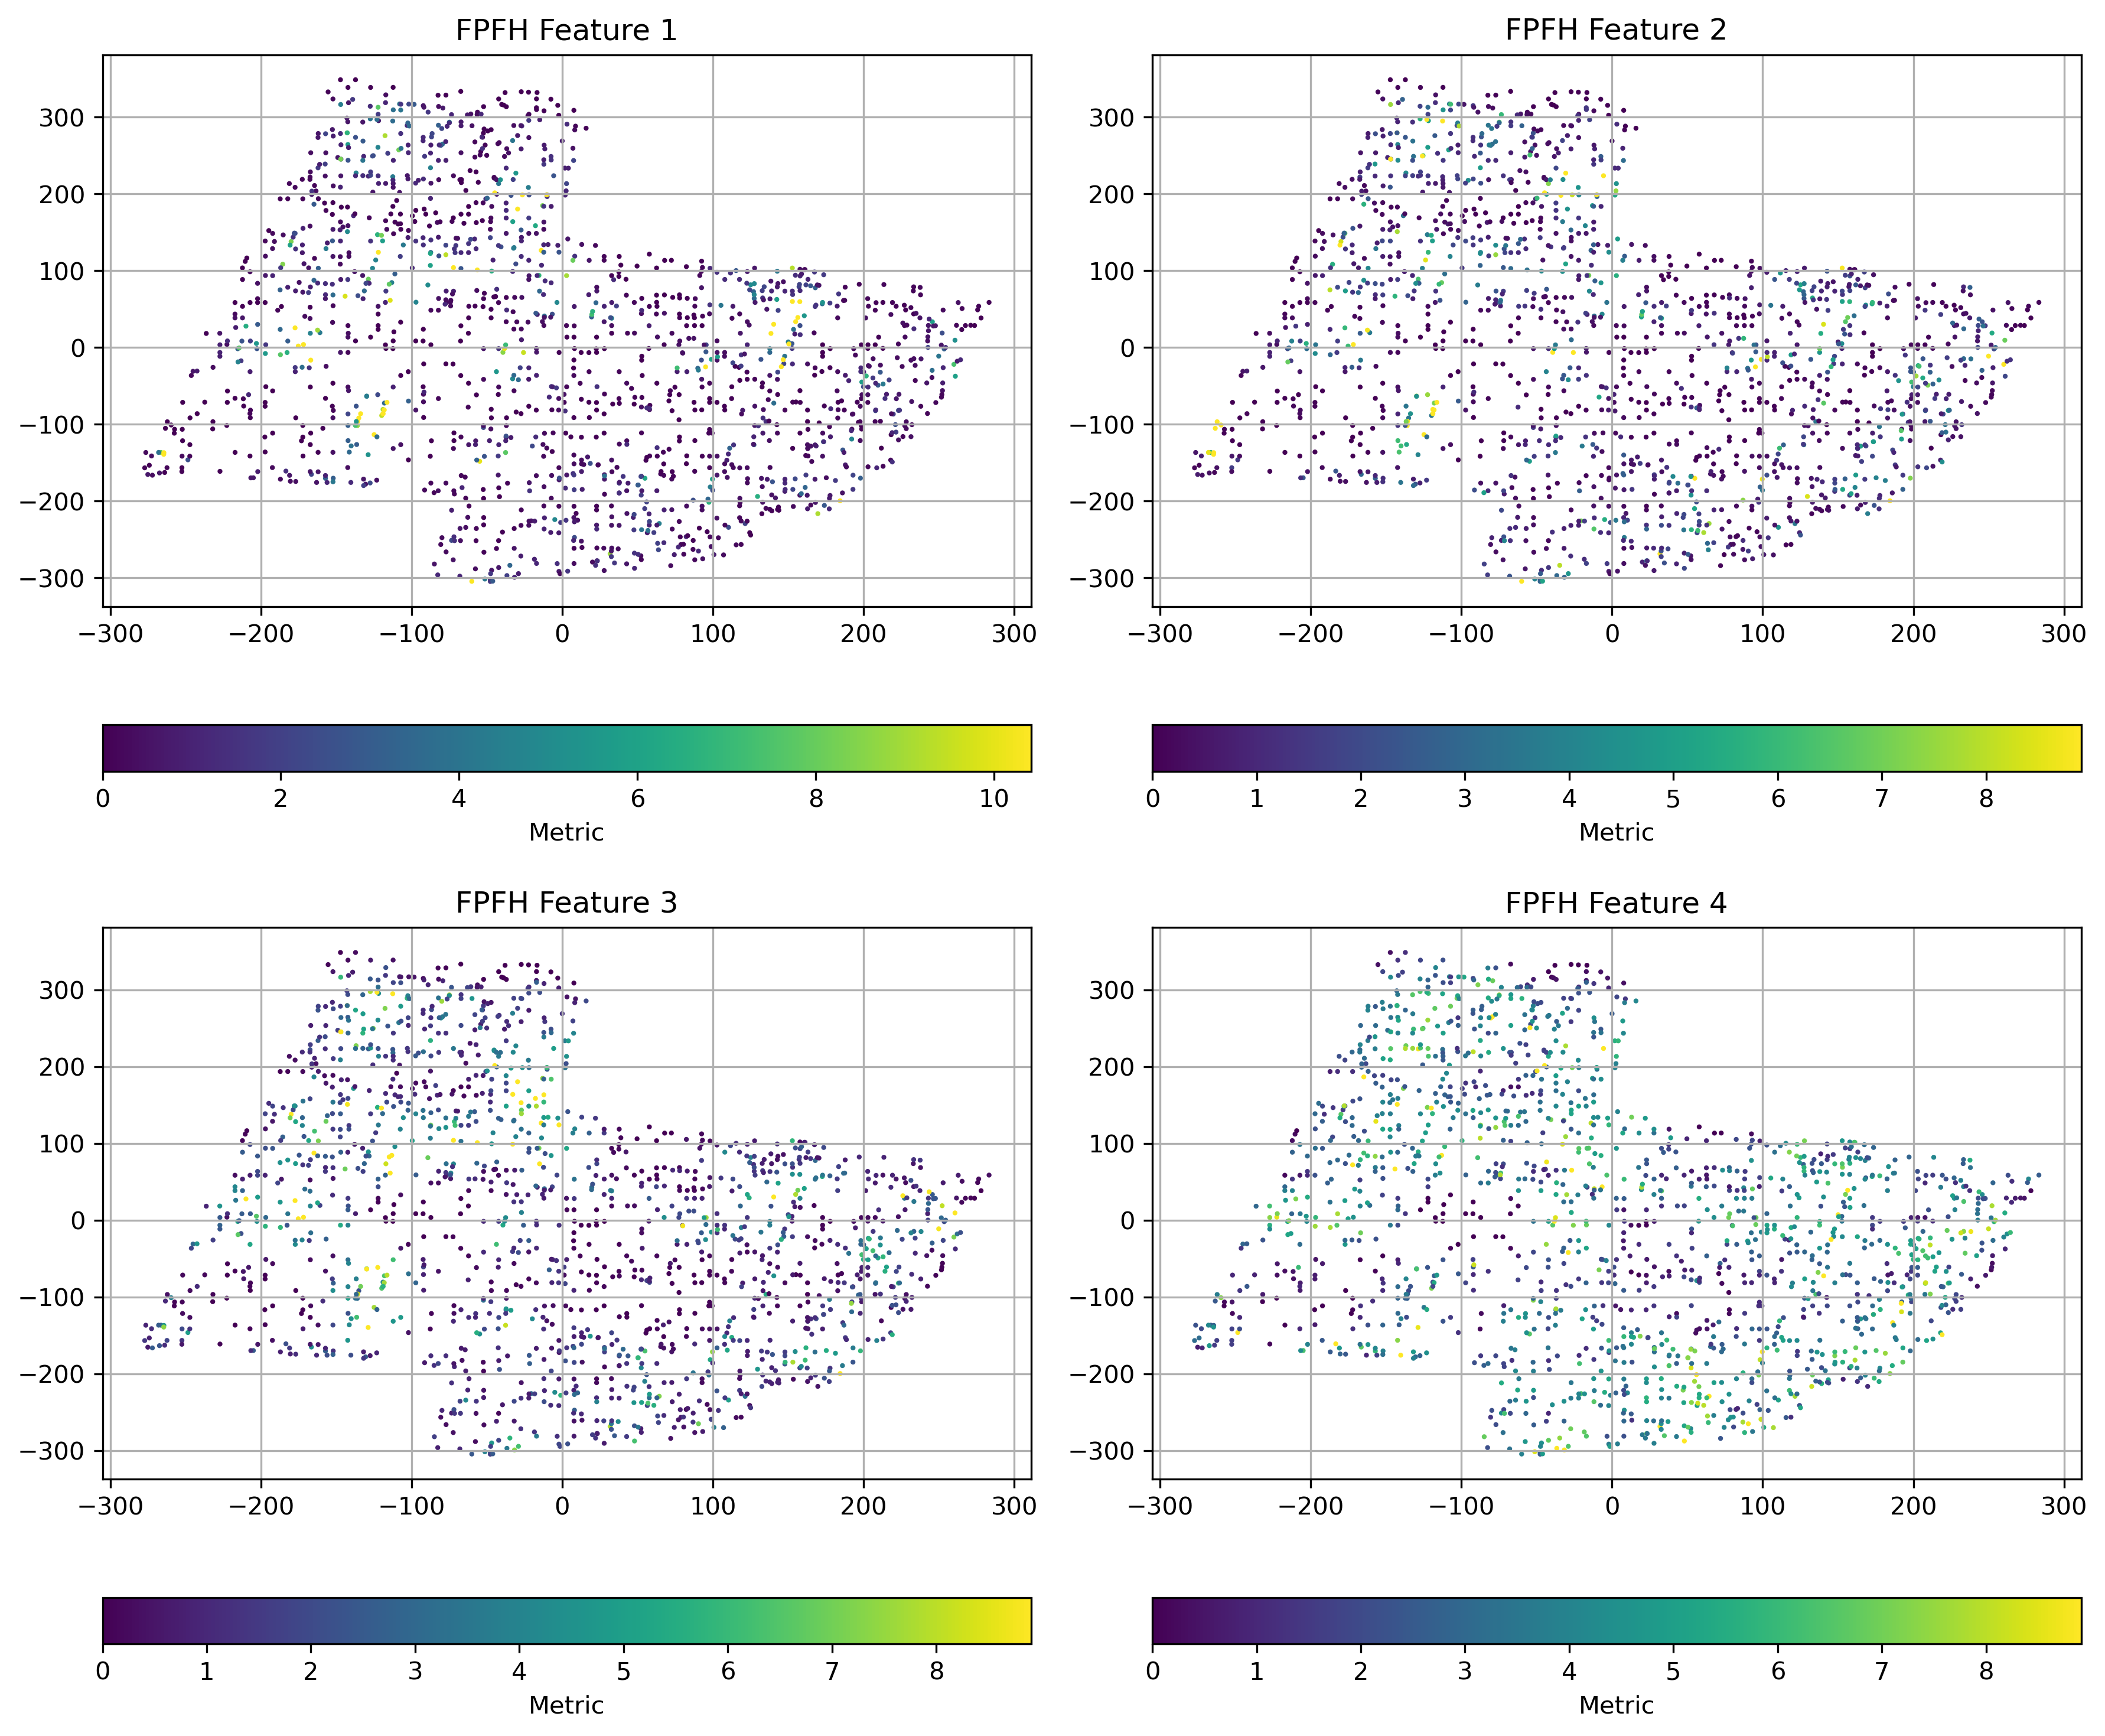

In [35]:
fg, ax = pl.subplots(nrows=2, ncols=2, figsize=(12,10), dpi=300)
x_mean = np.mean(np.asarray(source_5m.points)[::10,0])
y_mean = np.mean(np.asarray(source_5m.points)[::10,1])

im0 = ax[0,0].scatter(np.asarray(source_5m.points)[::10,0]-x_mean, 
                   np.asarray(source_5m.points)[::10,1]-y_mean, 
           c=source_5m_fpfh.data[0,::10], s=1, cmap='viridis',
                   vmin=np.percentile(source_5m_fpfh.data[0,::10],2),
                  vmax=np.percentile(source_5m_fpfh.data[0,::10],98))
ax[0,0].grid()
ax[0,0].set_title('FPFH Feature 1')
cb0=pl.colorbar(im0, ax=ax[0,0], orientation='horizontal')
cb0.set_label('Metric')

im1 = ax[0,1].scatter(np.asarray(source_5m.points)[::10,0]-x_mean, 
                   np.asarray(source_5m.points)[::10,1]-y_mean, 
           c=source_5m_fpfh.data[1,::10], s=1, cmap='viridis',
                   vmin=np.percentile(source_5m_fpfh.data[1,::10],2),
                  vmax=np.percentile(source_5m_fpfh.data[1,::10],98))
ax[0,1].grid()
ax[0,1].set_title('FPFH Feature 2')
cb1=pl.colorbar(im1, ax=ax[0,1], orientation='horizontal')
cb1.set_label('Metric')

im2 = ax[1,0].scatter(np.asarray(source_5m.points)[::10,0]-x_mean, 
                   np.asarray(source_5m.points)[::10,1]-y_mean, 
           c=source_5m_fpfh.data[2,::10], s=1, cmap='viridis',
                   vmin=np.percentile(source_5m_fpfh.data[2,::10],2),
                  vmax=np.percentile(source_5m_fpfh.data[2,::10],98))
ax[1,0].grid()
ax[1,0].set_title('FPFH Feature 3')
cb2=pl.colorbar(im1, ax=ax[1,0], orientation='horizontal')
cb2.set_label('Metric')

im3 = ax[1,1].scatter(np.asarray(source_5m.points)[::10,0]-x_mean, 
                   np.asarray(source_5m.points)[::10,1]-y_mean, 
           c=source_5m_fpfh.data[3,::10], s=1, cmap='viridis',
                   vmin=np.percentile(source_5m_fpfh.data[3,::10],2),
                  vmax=np.percentile(source_5m_fpfh.data[3,::10],98))
ax[1,1].grid()
ax[1,1].set_title('FPFH Feature 4')
cb3=pl.colorbar(im1, ax=ax[1,1], orientation='horizontal')
cb3.set_label('Metric')


fg.tight_layout()

Perform Global Registration using the neighborhood information to match only points that should be matched (because they have a similar neighborhood patterns). This may be slow.

In [36]:
distance_threshold = MHausdorf_D*2

result_fgr = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_5m, target_5m, source_5m_fpfh, target_5m_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))

print(result_fgr.transformation)

[[ 9.99676626e-01  2.51374151e-02  3.84104737e-03 -1.45901373e+05]
 [-2.51270281e-02  9.99680542e-01 -2.72894620e-03  1.09605390e+04]
 [-3.90841897e-03  2.63154963e-03  9.99988900e-01 -1.39055551e+04]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00]]


Verify that point clouds are aligned by plotting them with `draw_registration_result(source, target, transformation)`.

In [37]:
draw_registration_result(source_5m, target_5m, result_fgr.transformation)

An alternative Global Registration approach is to use a RANSAC-based approach that is subsampling the point cloud and uses a much smaller number of samples.

In [38]:
distance_threshold = MHausdorf_D*2
print(":: RANSAC registration on downsampled point clouds.")
print("   distance threshold %.3f m." % distance_threshold)
result_ransac = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_5m, target_5m, source_5m_fpfh, target_5m_fpfh, True,
    distance_threshold,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
    3, [
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
            0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
            distance_threshold)
    ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))

print(result_ransac.transformation)

:: RANSAC registration on downsampled point clouds.
   distance threshold 60.187 m.
[[ 9.99997457e-01  6.77997136e-04  2.15077948e-03 -3.93689368e+03]
 [-6.79706889e-04  9.99999454e-01  7.94314803e-04  2.49028451e+02]
 [-2.15023977e-03 -7.95774683e-04  9.99997372e-01  5.36477136e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Verify that point clouds are aligned by plotting them with `draw_registration_result(source, target, transformation)`.

In [39]:
draw_registration_result(source_5m, target_5m, result_ransac.transformation)

### Useful addition

We can apply the transformation matrix to the 1m point cloud. Make sure to put in right order: SOURCE and Target.

In [204]:
pcd2_1m_reg = copy.deepcopy(pcd2_1m)
pcd2_1m_reg.transform(result_ransac.transformation)

PointCloud with 438252 points.

### What does our distance distribution look like after this alignment step?

We use the transformation matrix derived from the 5 m subsampled dataset and apply this to the original or 1 m dataset.

In [40]:
from scipy.spatial import cKDTree

target_temp = copy.deepcopy(pcd2_1m)
target_temp.transform(result_ransac.transformation)

A = np.asarray(target_temp.points)
B = np.asarray(pcd_1m.points)

# KDtree Distances
d1_gr, _ = cKDTree(A).query(B, k=1, workers=-1)
d2_gr, _ = cKDTree(B).query(A, k=1, workers=-1)

target_temp=None

In [41]:
Hausdorf_D_gr = np.max([np.max(d1_gr), np.max(d2_gr)])
print('Initial Hausdorff Distance: %2.2f'%Hausdorf_D)
print('Global Registration Hausdorff Distance: %2.2f'%Hausdorf_D_gr)

Initial Hausdorff Distance: 54.39
Global Registration Hausdorff Distance: 43.67


In [42]:
MHausdorf_D_gr = np.max([np.mean(d1_gr), np.mean(d2_gr)])
print('Initial Modified Hausdorff Distance: %2.2f'%MHausdorf_D)
print('Global Registration Modified Hausdorff Distance: %2.2f'%MHausdorf_D_gr)

Initial Modified Hausdorff Distance: 30.09
Global Registration Modified Hausdorff Distance: 2.32


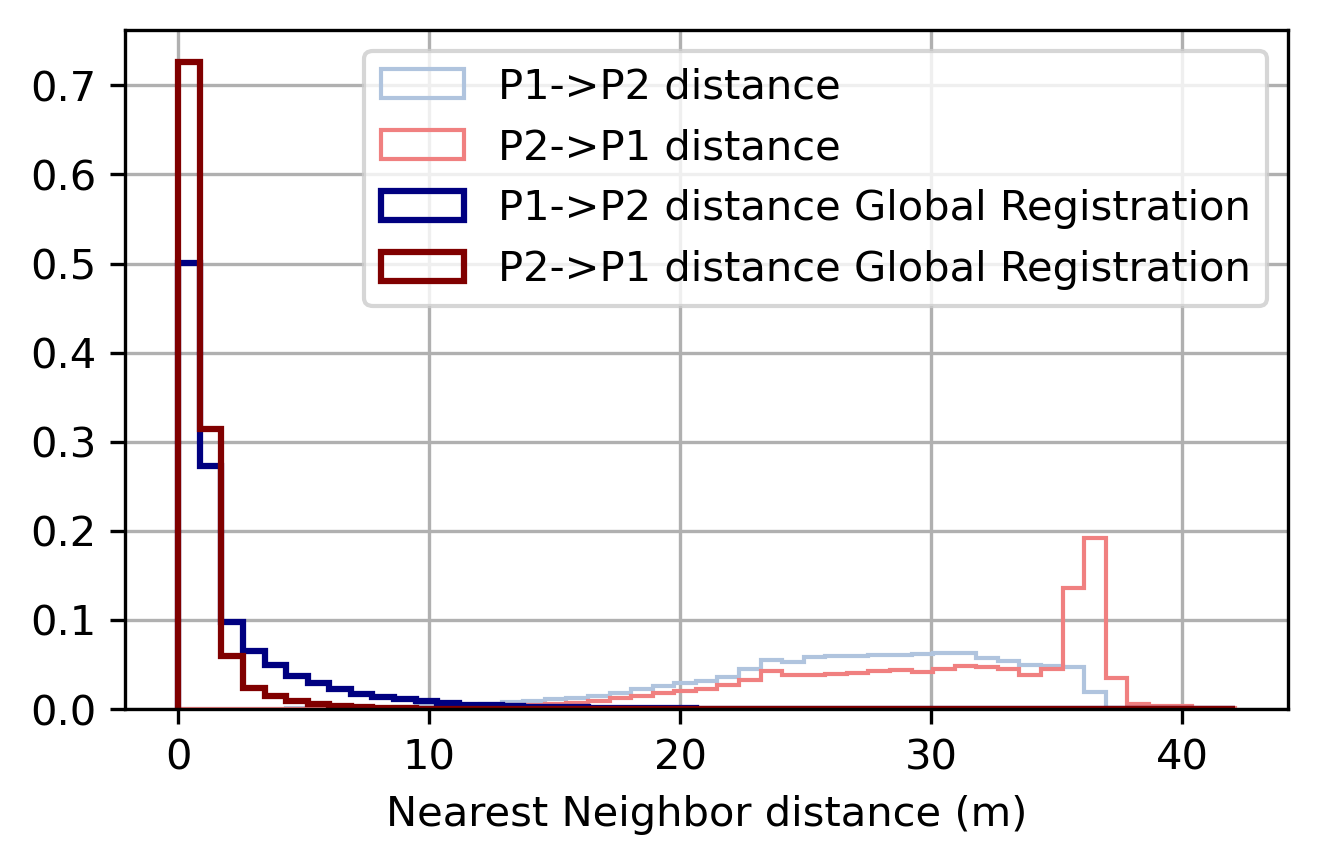

In [43]:
bins50 = np.linspace(0, np.max(d1), 50, endpoint=True)

fg, ax = pl.subplots(nrows=1, ncols=1, figsize=(5,3), dpi=300)

ax.hist(d1, bins=bins50, density=True, histtype='step', label='P1->P2 distance', color='lightsteelblue')
ax.hist(d2, bins=bins50, density=True, histtype='step', label='P2->P1 distance', color='lightcoral')
ax.hist(d1_gr, bins=bins50, density=True, histtype='step', 
        label='P1->P2 distance Global Registration', color='navy', lw=1.5)
ax.hist(d2_gr, bins=bins50, density=True, histtype='step', label='P2->P1 distance Global Registration', color='maroon', lw=1.5)
ax.legend()
ax.set_xlabel('Nearest Neighbor distance (m)')
ax.grid()

## 6. Fine Alignment (ICP: Iterative Closest Point)

Once the point clouds are roughly aligned, we can perform the fine alignment. Here, we will use the 1 m point cloud, because we will need to rely on additional features and more neighborhood information.

In [44]:
source = copy.deepcopy(pcd2_1m).transform(result_ransac.transformation) #point cloud you want to align (to be moved)
target = copy.deepcopy(pcd_1m) # reference point cloud
max_correspondence_distance = MHausdorf_D_gr*2 # No larger distances will be matched

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, max_correspondence_distance, 
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)

RegistrationResult with fitness=9.845089e-01, inlier_rmse=9.239011e-01, and correspondence_set size of 431463
Access transformation to get result.
Transformation is:
[[ 9.99998381e-01 -7.09095476e-04 -1.65373888e-03  4.11872337e+03]
 [ 7.02827172e-04  9.99992579e-01 -3.78788890e-03 -2.10971148e+02]
 [ 1.65641258e-03  3.78672047e-03  9.99991458e-01 -2.25951356e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


##### What does this look like? Are the two point clouds aligned? Verify!

In [45]:
draw_registration_result(source, target, reg_p2p.transformation)

If this looks ok, perform transformation for full point cloud with the Transformation matrix and verify again:

In [46]:
pcd2_r = source.transform(reg_p2p.transformation)
draw_2pcd(target, pcd2_r)

This looks reasonable. Now, you can use the transformation matrix in *CloudCompare*, *pdal*, or *lastools* to convert the original point cloud.

You can repeat this with the full resolution point cloud - but this will be significantly slower.

### Distance distribution of ICP aligned dataset

In [47]:
from scipy.spatial import cKDTree

A = np.asarray(target.points)
B = np.asarray(pcd2_r.points)

# Hausdorff distance
d1_icp, _ = cKDTree(A).query(B, k=1, workers=-1)
d2_icp, _ = cKDTree(B).query(A, k=1, workers=-1)

In [48]:
MHausdorf_D_icp = np.max([np.mean(d1_icp), np.mean(d2_icp)])
print('Initial Modified Hausdorff Distance: %2.2f'%MHausdorf_D)
print('Global Registration Modified Hausdorff Distance: %2.2f'%MHausdorf_D_gr)
print('ICP Modified Hausdorff Distance: %2.2f'%MHausdorf_D_icp)

Initial Modified Hausdorff Distance: 30.09
Global Registration Modified Hausdorff Distance: 2.32
ICP Modified Hausdorff Distance: 2.11


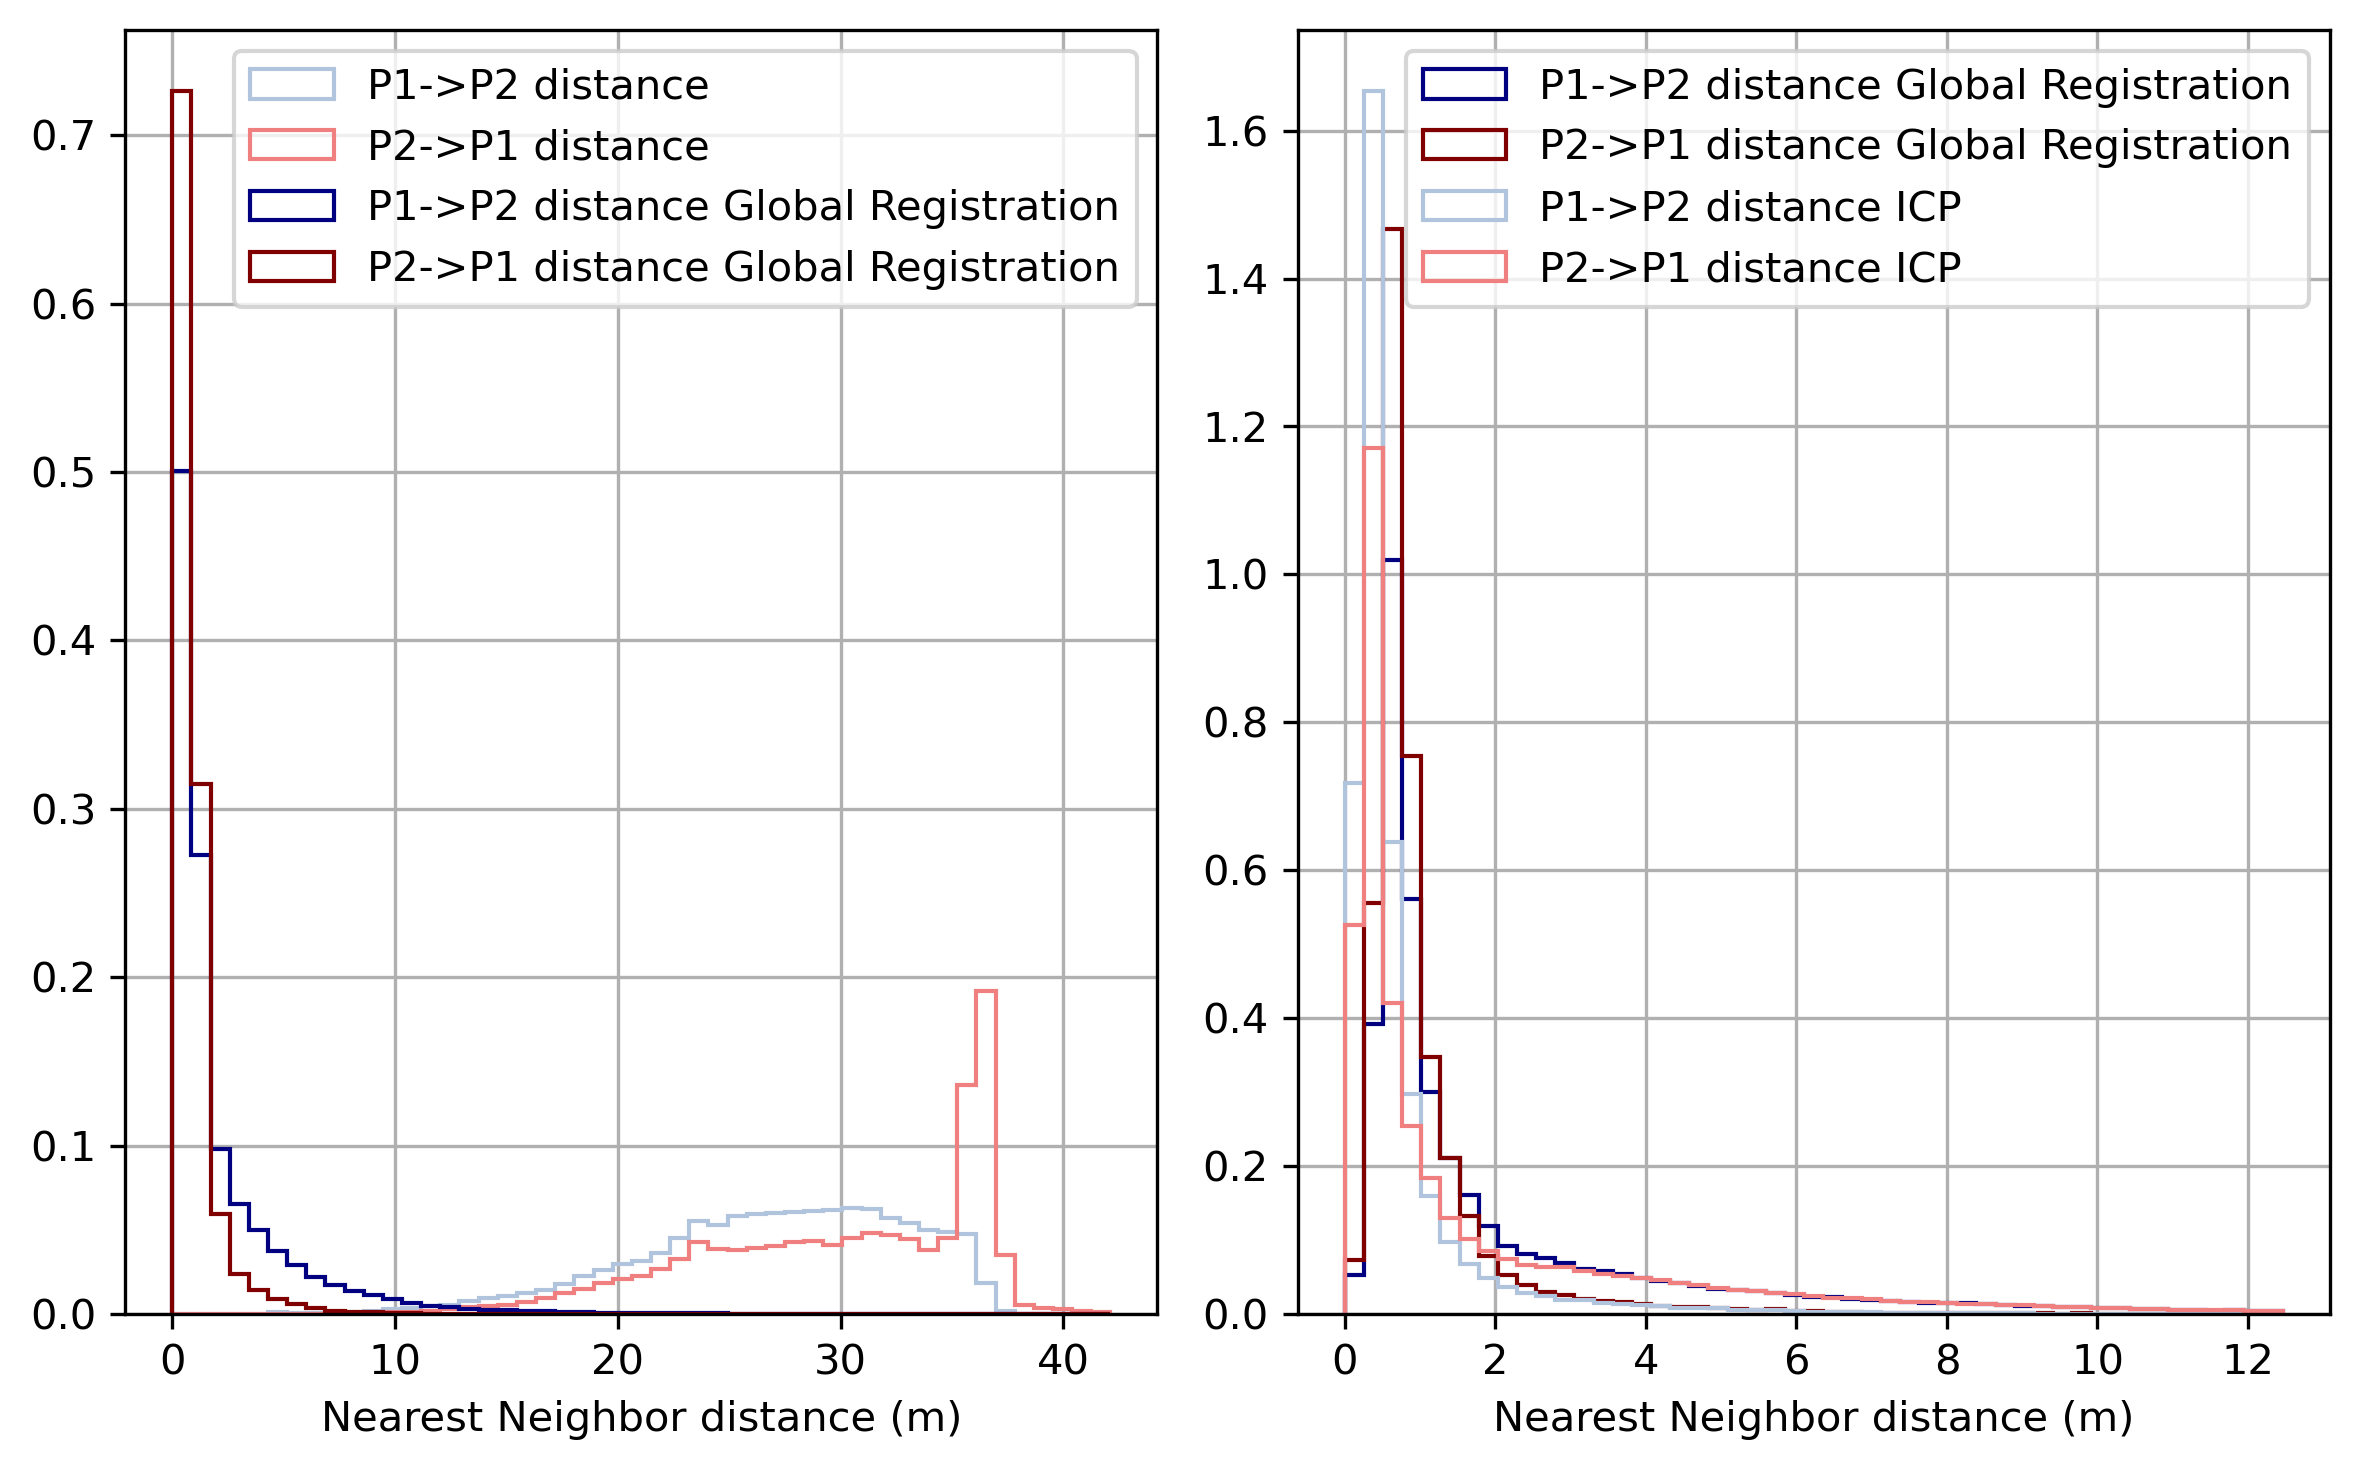

In [49]:
fg, ax = pl.subplots(nrows=1, ncols=2, figsize=(8,5), dpi=300)

bins50 = np.linspace(0, np.max(d1), 50, endpoint=True)
ax[0].hist(d1, bins=bins50, density=True, histtype='step', label='P1->P2 distance', color='lightsteelblue')
ax[0].hist(d2, bins=bins50, density=True, histtype='step', label='P2->P1 distance', color='lightcoral')
ax[0].hist(d1_gr, bins=bins50, density=True, histtype='step', 
        label='P1->P2 distance Global Registration', color='navy')
ax[0].hist(d2_gr, bins=bins50, density=True, histtype='step', label='P2->P1 distance Global Registration', color='maroon')
ax[0].legend()
ax[0].set_xlabel('Nearest Neighbor distance (m)')
ax[0].grid()

bins50_gr = np.linspace(0, np.percentile(d1_gr,98), 50, endpoint=True)
ax[1].hist(d1_gr, bins=bins50_gr, density=True, histtype='step', 
        label='P1->P2 distance Global Registration', color='navy')
ax[1].hist(d2_gr, bins=bins50_gr, density=True, histtype='step', 
           label='P2->P1 distance Global Registration', color='maroon')
ax[1].hist(d1_icp, bins=bins50_gr, density=True, histtype='step', 
        label='P1->P2 distance ICP', color='lightsteelblue')
ax[1].hist(d2_icp, bins=bins50_gr, density=True, histtype='step', 
           label='P2->P1 distance ICP', color='lightcoral')
ax[1].legend()
ax[1].set_xlabel('Nearest Neighbor distance (m)')
ax[1].grid()

fg.tight_layout()